In [1]:
import codecs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyemd

import nltk
from nltk.translate.bleu_score import sentence_bleu
from nltk.corpus import stopwords as sw
from nltk.stem import PorterStemmer
from nltk.lm.models import Laplace
from nltk.corpus import reuters
from nltk.lm.preprocessing import padded_everygram_pipeline
from nltk.lm import Vocabulary

from gensim.models import Word2Vec
import gensim.downloader

from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE

from scipy.ndimage import gaussian_filter1d
from time import sleep

In [2]:
nltk.download('stopwords')
nltk.download('punkt')
stopwords = set(sw.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\caleb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\caleb\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
def txt_to_df(fname):
    data = codecs.open(fname, 'r', encoding='utf8').read().split('\n\n')
    data = [row.split("\n") for row in data]

    # there's an empty line at the end of the file that was being included as a feature in the final item, so delete it
    del data[-1][-1]

    df = pd.DataFrame(data, columns=['chinese', 'reference', 'candidate', 'bleu', 'M_or_H'])
    df['bleu'] = df['bleu'].astype(float)
    return df

In [4]:
def get_X_and_Y(data, x_cols, y_col):
    return data.loc[:, x_cols], data[y_col]

In [5]:
def avg_f1_score(actual, preds):
    
    def f1_score(pos_label):
        # get count of true positives, false positives, and false negatives
        tp = sum(1 for a, p in zip(actual, preds) if a == p == pos_label)
        fp = sum(1 for a, p in zip(actual, preds) if a != pos_label and p == pos_label)
        fn = sum(1 for a, p in zip(actual, preds) if a == pos_label and p != pos_label)
        
        return tp/(tp + (fp + fn)/2)
        
    return (f1_score('H') + f1_score('M'))/2

In [6]:
def accuracy(actual, preds):
    return sum(1 for a, p in zip(actual, preds) if a == p)/len(actual)

In [7]:
def bleu_score(reference, candidate, n):
    # expects a list of references, so put it in a list by itself
    reference = [reference.split(" ")]
    candidate = candidate.split(" ")
    weights = [1 if i == n-1 else 0 for i in range(4)]
    return sentence_bleu(reference, candidate, weights=weights)

In [8]:
# load pre-trained model for word vectors
word_vectors = gensim.downloader.load("glove-wiki-gigaword-100")
# normalize vectors to unit length
word_vectors.init_sims(replace=True)

In [9]:
# object used to remove word stems
stemmer = PorterStemmer()

In [10]:
# load and preprocess English news corpus
# corpus comes from COCA text_news, at https://www.corpusdata.org/formats.asp
# some preprocessing was involved outside of Python to break it up into manageable lines
news_sents = []
with open("text_news_pp.txt") as infile:
    for line in infile:
        words = list(map(str.lower, nltk.tokenize.word_tokenize(line)))
        curr_sent = []
        # considered spoiled if the first sentence in the line or an html tag
        spoiled = True
        for word in words:
            if not word:
                continue
            # spoil if we see an html tag
            if word[0] == '>':
                spoiled = True
            if not spoiled:
                curr_sent.append(word)
            # when we see a period, reset, and save to news_sents if not spoiled
            if word == '.':
                if not spoiled:
                    news_sents.append(curr_sent)
                spoiled = False
                curr_sent = []

In [11]:
# train a language model on the preprocessed news dataset
# adapted from https://stackoverflow.com/questions/54941966/
train_data = [nltk.trigrams(t,  pad_right=True, pad_left=True, left_pad_symbol="<s>", right_pad_symbol="</s>") for t in news_sents]
words = {word for sent in news_sents for word in sent}
words.update(["<s>", "</s>"])
padded_vocab = Vocabulary(words)
lang_model = Laplace(3)
lang_model.fit(train_data, padded_vocab)

In [12]:
def preprocess_best_vec_matches(sentence):
    # split by spaces
    sentence = sentence.split(" ")
    
    result = []
    for w in sentence:
        w_stem = stemmer.stem(w)
        w_in_vocab = w in word_vectors.wv.vocab
        w_stem_in_vocab = w_stem in word_vectors.wv.vocab
        
        # if the stem isn't in vocab, the next best thing is the original word
        if w not in stopwords and len(w) > 1 and (w_in_vocab or w_stem_in_vocab):
            if w_stem_in_vocab:
                result.append(w_stem)
            else:
                result.append(w)
                
    return result

In [13]:
# the same as the last method, but no stemming; this worked better experimentally
# probably because the last method still let through some stems that aren't common words, like "la" and "vega" for las vegas
# the previous method would work, if the dataset used to train the word-vector model was already stemmed
def preprocess_best_vec_matches_no_stem(sentence):
    # split by spaces
    sentence = sentence.split(" ")
    
    result = []
    for w in sentence:
        if w not in stopwords and len(w) > 1 and w in word_vectors.wv.vocab:
            result.append(w)
                
    return result

In [14]:
# converts words to vectors and finds the closest match for each word in the candidate
def best_vec_matches(reference, candidate):
    # first, remove all stopwords, punctuation, and words not in vocab, then stem if possible
    reference = preprocess_best_vec_matches_no_stem(reference)
    candidate = preprocess_best_vec_matches_no_stem(candidate)
    
#     print("reference words: " + str(reference), "candidate words: " + str(candidate), sep="\n")
    
    # find the most similar word in the reference for each word in the candidate
    result = []
    for c_word in reference:
        # find the best word to fit c_word
        max_sim = -float("inf")
        max_sim_word = None
        for r_word in candidate:
            sim = word_vectors.similarity(c_word, r_word)
            if max_sim < sim:
                max_sim = sim
                max_sim_word = r_word
#         print("Score {}: {}, {}".format(max_sim, c_word, max_sim_word))
        result.append(max_sim)
        
    # what is the score for the word with the worst match?
    return sorted(result)

In [15]:
# add bleu scores for various n-grams
def add_bleu_scores(df):
    for n in range(1, 5):
        df['bleu' + str(n)] = df.apply(lambda row: bleu_score(row['reference'], row['candidate'], n), axis=1)

# use word2vec to get the three smallest/worst "best vector matches"
def add_smallest_best_vector_matches(df):
    num_vec_matches = 3
    vec_matches = [[] for _ in range(num_vec_matches)]
    
    for row in df.itertuples():
        matches = best_vec_matches(row.reference, row.candidate)
        for m in range(num_vec_matches):
            # if matches is not long enough, just append a score of 1 instead
            vec_matches[m].append(matches[m] if m < len(matches) else 1)
    
    for i in range(num_vec_matches):
        df['vec_match_' + str(i)] = vec_matches[i]

# word mover's distance is an existing metric for determining similarity between sentences
def add_word_movers_distance(df):
    def wmdist(row):
        cand_split = row.candidate.split(" ")
        ref_split = row.reference.split(" ")
        return word_vectors.wmdistance(cand_split, ref_split)
    df['wmdist'] = df.apply(wmdist, axis=1)

# use a language model to estimate the perplexity of the sentence
def add_perplexity(df):
    def perplexity(row):
        perplex_text = list(map(str.lower, nltk.tokenize.word_tokenize(row.candidate)))
        padded_text = nltk.trigrams(perplex_text, pad_right=True, pad_left=True,
                                    left_pad_symbol="<s>", right_pad_symbol="</s>")
        return lang_model.perplexity(padded_text)
        
    df['perplexity'] = df.apply(perplexity, axis=1)

# get the word count of the candidate and the reference
def add_word_counts(df):
    df['chinese_word_count'] = df.apply(lambda row: len(row.chinese.split(" ")), axis=1)
    df['cand_word_count'] = df.apply(lambda row: len(row.candidate.split(" ")), axis=1)
    df['ref_word_count'] = df.apply(lambda row: len(row.reference.split(" ")), axis=1)

In [17]:
def add_features(df):
    add_bleu_scores(df)
    add_smallest_best_vector_matches(df)
    add_word_movers_distance(df)
    add_perplexity(df)
    add_word_counts(df)

In [18]:
og_train = txt_to_df("train.txt")
og_test = txt_to_df("test.txt")
add_features(og_train)
add_features(og_test)
all_data = pd.concat([og_train, og_test])

C:\Users\caleb\Anaconda3\lib\site-packages\nltk\translate\bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\caleb\Anaconda3\lib\site-packages\nltk\translate\bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\caleb\Anaconda3\lib\site-packages\nltk\translate\bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnin

In [19]:
# set X and Y columns
all_x_cols = ['bleu', 'bleu1', 'bleu2', 'bleu3', 'bleu4', 'vec_match_0', 'vec_match_1', 'vec_match_2', "chinese_word_count", "ref_word_count", "cand_word_count", 'wmdist', 'perplexity']
x_cols = ['bleu', 'bleu1', 'bleu2', 'vec_match_0', "chinese_word_count", "ref_word_count", "cand_word_count", 'perplexity']
#x_cols = ["perplexity"]
y_col = 'M_or_H'

Mean Train F1:  0.7828714089848381
Mean Test F1:  0.7724010313700773


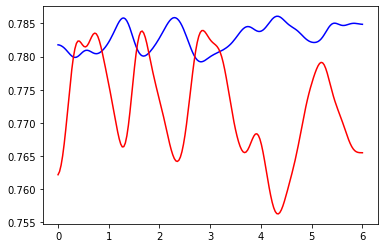

In [20]:
# I used this code to test and select multiple hyperparameters, in this case the C value for the SVM.
num_trials = 200
train_f1 = np.zeros(num_trials)
test_f1 = np.zeros(num_trials)
linspace = np.linspace(0, 6, num=num_trials)
for i, log_C in enumerate(linspace): # previously used this to test different hyperparameters
    C = 2**log_C
    train, test = train_test_split(all_data, test_size=0.2)
    trainX, trainY = get_X_and_Y(train, x_cols, y_col)
    testX, testY = get_X_and_Y(test, x_cols, y_col)

    # preprocess for scale and mean
    scaler = preprocessing.StandardScaler().fit(trainX)
    trainX_scaled = scaler.transform(trainX)
    testX_scaled = scaler.transform(testX)

    # fit to train data and predict trainY and testY
    svc = SVC(gamma='auto', kernel='linear', C=C)
    svc.fit(trainX_scaled, trainY)
    train_preds = svc.predict(trainX_scaled)
    test_preds = svc.predict(testX_scaled)
    
    train_f1[i] = avg_f1_score(trainY, train_preds)
    test_f1[i] = avg_f1_score(testY, test_preds)
    
smooth_factor = 5
train_f1_smoothed = gaussian_filter1d(train_f1[:67000], smooth_factor)
test_f1_smoothed = gaussian_filter1d(test_f1[:67000], smooth_factor)
plt.plot(linspace[:67000], train_f1_smoothed, color='blue')
plt.plot(linspace[:67000], test_f1_smoothed, color='red')

print("Mean Train F1: ", np.mean(train_f1))
print("Mean Test F1: ", np.mean(test_f1))

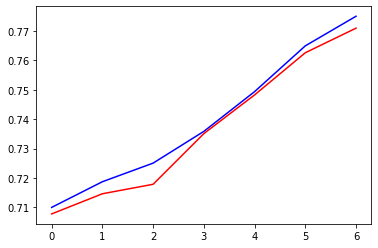

In [21]:
# This is similar code, but set up to test which features should be used, determined by RFE
num_trials = 100
train_f1 = np.zeros((num_trials, len(x_cols)))
test_f1 = np.zeros((num_trials, len(x_cols)))
for trial in range(num_trials):
    train, test = train_test_split(all_data, test_size=0.2)
    trainX, trainY = get_X_and_Y(train, x_cols, y_col)
    testX, testY = get_X_and_Y(test, x_cols, y_col)

    # preprocess for scale and mean
    scaler = preprocessing.StandardScaler().fit(trainX)
    trainX_scaled = scaler.transform(trainX)
    testX_scaled = scaler.transform(testX)

    svc = SVC(gamma='auto', kernel='linear', C=0.5)
    
    # try removing varying numbers of features to reduce overfitting
    selector = RFE(svc, n_features_to_select=1, step=1)
    selector = selector.fit(trainX_scaled, trainY)
    ranking = selector.ranking_
    for rank in range(len(ranking)):
        # rank starts from 0, but the ranks in ranking start from 1
        trainX_selected = trainX_scaled[:, [r <= rank+1 for r in ranking]]
        testX_selected = testX_scaled[:, [r <= rank+1 for r in ranking]]

        # fit to train data and predict trainY and testY
        svc.fit(trainX_selected, trainY)
        train_preds = svc.predict(trainX_selected)
        test_preds = svc.predict(testX_selected)
    
        train_f1[trial, rank] = avg_f1_score(trainY, train_preds)
        test_f1[trial, rank] = avg_f1_score(testY, test_preds)
    
plt.plot(range(len(x_cols)), np.mean(train_f1, axis=0), color='blue')
plt.plot(range(len(x_cols)), np.mean(test_f1, axis=0), color='red')

In [22]:
# train and test on the original train/test datasets
trainX, trainY = get_X_and_Y(og_train, x_cols, y_col)
testX, testY = get_X_and_Y(og_test, x_cols, y_col)

# preprocess for scale and mean
scaler = preprocessing.StandardScaler().fit(trainX)
trainX_scaled = scaler.transform(trainX)
testX_scaled = scaler.transform(testX)

# fit to train data and predict trainY and testY
svc = SVC(gamma='auto', kernel='linear', C=8)
svc.fit(trainX_scaled, trainY)
train_preds = svc.predict(trainX_scaled)
test_preds = svc.predict(testX_scaled)

print("Train F1: ", avg_f1_score(trainY, train_preds))
print("Test F1: ", avg_f1_score(testY, test_preds))

Train F1:  0.7765481516364492
Test F1:  0.7816091954022989
